In [5]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import time
import heapq
import subprocess
from subprocess import Popen, PIPE, STDOUT
import time
!chmod +x spike-dasm.exe

In [32]:
# Read JSON
with open('rv64um-v-mul.out', 'r') as f:
    json_lines = f.readlines()

inst_jsons = []
for line in json_lines:
    try:
        inst_jsons.append(json.loads(line))
    except json.JSONDecodeError:
        pass

In [31]:
p = Popen("./spike-dasm.exe", stdout=PIPE, stdin=PIPE, stderr=PIPE, text=True, shell=True)
stdout_data = p.communicate(input=f"DASM(0x0001041f)")
stdout_data

('unknown\n', '')

In [33]:
def generate_data_array(jsons):
    arr = []
    for json in jsons:
        if json["event_name"] == "EX":
            p = Popen("./spike-dasm.exe", stdout=PIPE, stdin=PIPE, stderr=PIPE, text=True, shell=True)
            stdout_data = p.communicate(input=f"DASM({json['data']})")[0].strip()
            arr.append(stdout_data)
        else:
            arr.append(json["data"])
    return np.array(arr)
inst_ids = np.array([inst_jsons[i]["id"] for i in range(len(inst_jsons))])
inst_cycle = np.array([inst_jsons[i]["cycle"].strip() for i in range(len(inst_jsons))])
inst_event = np.array([inst_jsons[i]["event_name"] for i in range(len(inst_jsons))])
data_field = generate_data_array(inst_jsons)
inst_parent = np.array([inst_jsons[i]["parents"] for i in range(len(inst_jsons))])
data = np.column_stack((inst_ids,inst_parent, inst_cycle, inst_event, data_field))
columns = ["inst_id", "parent_id", "cycle", "stage", "data"]
df = pd.DataFrame(data=data, columns=columns)

,inst_id,parent_id,cycle,stage,data
0,0x0000000000000000,None,0,IF1,0x0000010040
1,0x0000000000000001,None,1,IF1,0x0000010044
2,0x0000000100000001,0x0000000000000000,1,IF2,0x0000010040
3,0x0000000000000002,None,2,IF1,0x0000010040
4,0x0000000000000003,None,3,IF1,0x0000010044
...,...,...,...,...,...
597466,0x0000000000087758,None,554840,IF1,0xffffe022c0
597467,0x0000000100087758,0x0000000000087757,554840,IF2,0xffffe022bc
597468,0x0000000400087758,0x0000000100087757,554840,EX,"c.fld fa5, 64(a3)"
597469,0x0000000500087758,0x0000000400087757,554840,MEM,0xffffe022bc


In [36]:
def construct_graph(df):
    DG = nx.DiGraph()
    for row in df.itertuples():
        DG.add_node(row.inst_id, cycle=row.cycle, data=row.data, stage=row.stage)
        if row.parent_id != "None":
            DG.add_edge(row.parent_id, row.inst_id)
    return DG

def construct_speculative_trace(G):
    paths = []
    id = 0
    for node in G:
        data = G.nodes[node]
        if G.in_degree(node) == 0: # root node
            new_paths = trace_down(G, node, [], [])
            paths.extend(new_paths)
    for path in paths:
        if path[-1][0] != "RET":
            path.append(("FLUSH", str(int(path[-1][1]) + 1), None))
        path.insert(0, (id, path[0][-1]))
    return paths

def trace_down(G, node, curr_path, paths):
    data = G.nodes[node]
    curr_path.append((data["stage"], data["cycle"], data["data"]))
    if G.out_degree(node) == 0: # terminal node
        paths.append(curr_path)
        return paths
    succs = DG.successors(node)
    for n in succs:
        paths.extend(trace_down(G, n, curr_path[:], []))
    return paths

def construct_committed_trace(G):
    paths = []
    id = 0
    for node in G:
        data = G.nodes[node]
        if G.out_degree(node) == 0 and data["stage"] == "RET": # committed leaf node
            new_path = trace_up(G, node)
            new_path.insert(0, (id, data["data"]))
            paths.append(new_path)
            id += 1
    return paths

def trace_up(G, node):
    path = []
    while node:
        data = G.nodes[node]
        path.insert(0, (data["stage"], data["cycle"], data["data"]))
        node = list(DG.predecessors(node))[0] if list(DG.predecessors(node)) else ""
    return path
    

In [37]:
DG = construct_graph(df)

In [38]:
num_paths = 0
for node in DG:
    if DG.out_degree(node) == 0: # leaf node
        num_paths += 1
num_paths

555084

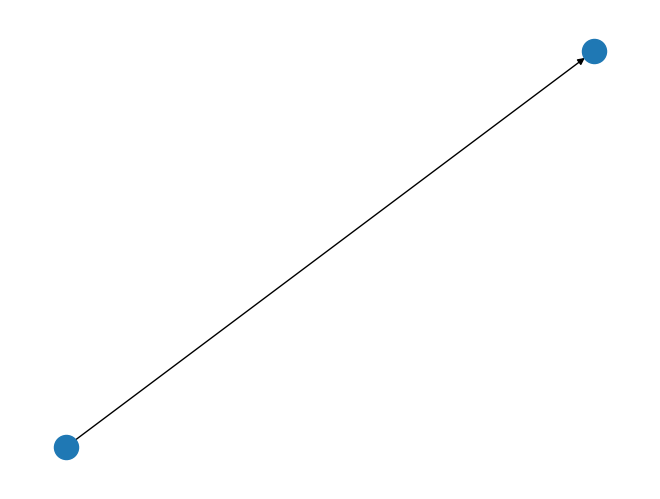

In [19]:
for node in DG:
    data = DG.nodes[node]
    if DG.in_degree(node) == 0: # committed leaf node
        nx.draw(DG.subgraph([node] + list(nx.descendants(DG, node))))
        break

In [7]:
paths = construct_committed_trace(DG)

In [39]:
spec_paths = construct_speculative_trace(DG)

In [40]:
filtered_paths = [p for p in spec_paths if int(p[0][1], 0) >= 0x80000000] 

In [43]:
import heapq

def convert_to_kanata(threads, verbose=False):
    pq = []
    id = 0
    if not verbose:
        threads = list(filter(lambda x: x[-1][0] == 'RET', threads)) #Relies on the last element of inst list being RET
    for inst in threads:
        for stage in inst[1:]:
            heapq.heappush(pq, ((int(stage[1])), (id, stage[2], stage[0]))) #Min heap of (cycle -> (unique_id, pc, pipeline stage))
        id += 1
            
    with open('mulf.log', 'w') as file:
        file.write('Kanata    0004\n')
        cycle, (id, pc, stage) = heapq.heappop(pq)
        prev_cycle = cycle
        file.write(f'C=\t{cycle}\n')
        while pq:
            cycle_diff = cycle - prev_cycle
            if (cycle_diff > 0):
                file.write(f"C\t{cycle_diff}\n")
            if (stage == 'IF1'):
                file.write(f"I\t{id}\t{cycle}\t0\n")
                # file.write(f"L    {id}    0    {pc}\n")
            if (stage == 'RET'):
                file.write(f"R\t{id}\t{id}\t0\n")
            elif (stage == 'FLUSH'):
                file.write(f"R\t{id}\t{id}\t1\n")
            elif (stage == "MEM"):
                file.write(f"S\t{id}\t0\t{stage}\n")
                file.write(f"L\t{id}\t0\tPC:{pc}\n")
            elif (stage == "EX"):
                file.write(f"S\t{id}\t0\t{stage}\n")
                file.write(f"L\t{id}\t0\t{pc} \n")
            else:
                file.write(f"S\t{id}\t0\t{stage}\n")
                file.write(f"L\t{id}\t1\tPC:{pc}\n")

            prev_cycle = cycle
            cycle, (id, pc, stage) = heapq.heappop(pq)

In [44]:
convert_to_kanata(filtered_paths, verbose=True)